# Analysis Ready Data Tutorial

Time-series analysis (e.g. change detection and trend detection) is a powerful application of satellite imagery. However, a great deal of processing is required to prepare imagery for analysis. Analysis Ready Data (ARD), preprocessed time-series stacks of overhead imagery, allow for time-series analysis without any additional processing of the imagery. See [Analysis Data Defined](https://medium.com/planet-stories/analysis-ready-data-defined-5694f6f48815) for an excellent introduction and discussion on ARD.

This tutorial shows how [Planet APIs](https://developers.planet.com/docs/apis/) can simplify production of ARD by demonstrating best practices and then by walking through a real world use case. This tutorial is targeted to users who have little to no geospatial knowledge but have experience working with APIs. The goal of this tutorial is to teach the user the how and whys of using the Data and Orders APIs to create and interpret ARD for both use cases. The use case addressed in this tutorial is:

* As a software engineer at an ag-tech company, I'd like to be able to order Planet imagery programmatically in a way that enables the data scientist at my organization to create time-series algorithms (e.g. monitoring ndvi curves over time) without further data cleaning and processing.


## APIs

The two Planet APIs that are used in creation of ARD are the [Data API](https://developers.planet.com/docs/data/) and the [Orders API](https://developers.planet.com/docs/orders/). The Data API is used to search for imagery according to certain criteria based on the use case, and the Orders API is used to process that imagery into ARD that can be fed directly into time-series analysis.

### Data API

The first step in using the Data API is identifying the search criteria. This is specifying answers to the following questions regarding the use case time-series analysis:
* What is the time range?
* What product item type is desired?
* What is the area of interest (geographic region)?
* What percentage of pixels need to be usable?
* etc.

While time range is likely pretty trivial to determine, product item, area of interest, and usable pixels may take a little bit of work. Let's dive into each further

#### Product Item Type

The [product item type](https://developers.planet.com/docs/data/items-assets/) refers to the sensor source (aka satellite type) and basic processing desired. This decision is highly dependent on application, as coverage, revisit rate, spectral bands, and resolution differ between products. A good overview of the products available in the Planet Data API is provided on the [Planet Imagery and Archive](https://www.planet.com/products/planet-imagery/) page (look for the link to product specs for details). For most frequent revisit rate, we will use the PS satellite. Experience has shown that customers most often use the scene (vs the orthotile) product. Therefore, this tutorial will focus on the `PSScene4Band` product.

#### Area of Interest

The area of interest is the geographic region for the analysis, given as GeoJSON. If you are familiar with JSON, the format of GeoJSON will likely be easy to grasp. According to <geojson.org>, "GeoJSON is a format for encoding a variety of geographic data structures." The specific geographic data structure we are interested is a `Polygon`. The [GeoJSON wikipedia page](https://en.wikipedia.org/wiki/GeoJSON) gives some great examples of the data structures for the various GeoJSON data structures. 

Some care needs to be given to describing the [position](https://tools.ietf.org/html/rfc7946#section-3.1.1) for each coordinate in a GeoJSON geometry. Each position is specified as `(longitude, latitude)` or `(easting, northing)` (order really matters here!). Also, this may be a surprise, but the same point on earth can have different `(longitude, latitude)` values based on the spatial reference system. Basically, a spatial reference system describes where something is in the real world. But there are thousands of different spatial reference systems. These are separated into two categories: geographic and projected. Geographic coordinate systems model the earth as an ellipsoid (this model is called the `datum`) and describe positions on the surface of the earth (coordinates) in terms of the prime meridian and angle of measure. Projected coordinate systems take this a step further by projecting the geographic coordinates (quite three-dimensional) into two dimensions (the `projection`). Different projections preserve different properties, such as area, angles, or direction for north. There is a rich area of discovery, discussion, and even a little [teasing](https://xkcd.com/977/) (thanks xkcd!) in the world of spatial reference systems.

GeoJSON only supports one spatial reference system, [WGS84](https://spatialreference.org/ref/epsg/wgs-84/). This is a geographic coordinate system describing locations in latitude, longitude. However, many web mapping applications use the Web Mercator projected coordinate system to to describe locations. Confusingly, Web Mercator also describes locations in latitude, longitude. But a `(longitude, latitude)` GeoJSON position given in Web Mercator will **not** end up where you expect if it is not first projected into WGS84. The easiest way to define an aoi that is described in WGS84 is to draw it in [Planet Explorer](https://www.planet.com/explorer) and click the little button "Download AOI as GeoJSON."

#### Usable Pixels

Taking pictures of the earth from space ain't easy. There are a lot of steps and a lot of things have to go right to get a clear shot. Therefore, not every pixel in every image taken from space is useful for analysis. For one, images taken from space are projected into a spatial reference system (discussed briefly above), a process that introduces some NoData (aka outside of the image footprint) pixels into the resulting image. Additionally, clouds cover a great deal of the earth and create cloudy pixels when imaged. While some applications can use cloudy pixels, others cannot. Therefore, the type of pixels that are determined to be 'usable' are often application-specific. To support definition of usable pixels, and filtering based on that definition, Planet provides Usable Data Masks along with Usable Data entries in the imagery metadata. For more details on the Usable Data Mask, check out (Clear for Analysis with Planet’s New Usable Data Masks)[https://www.planet.com/pulse/planets-new-usable-data-masks/]. For more information on the Usable Data metadata entries, see (Usable Data in Planet imagery)[https://developers.planet.com/planetschool/usable-data-in-planet-imagery/].

### Orders API

The core decision around using the orders api is which [product bundle](https://developers.planet.com/docs/orders/product-bundles-reference/) to use. This is the starting point for all processing and there are a lot of options. Once the product is determined, the processing steps (aka tools and toolchains) are defined. Finally, the logistics of the delivery of the imagery are ironed out.

#### Product Bundle

To enable time-series analysis, ARD imagery must be processed so that imagery is consistant across days, months, and possibly years. This means correcting for differences in camera sensitivities, the relative location of the sun, and the atmospheric conditions. The Analytic Radiance (`analytic`) product bundle provides imagery corrected for difference in camera sensitivities and location of the sun (as radiance) and can also remove the effect of the sun's spectrum by applying the `reflectanceCoefficient` value given in the imagery metadata. However, the Analytic Surface Reflectance (`analytic_sr`) product bundle removes the effect of atmospheric conditions while also converting to reflectance. Therefore, the Analytic Surface Reflectance is the ideal product for ARD and the one we will use here.

#### Tools and Toolchains

The [Tools and Toolchains](https://developers.planet.com/docs/orders/tools-toolchains/) functionality in the Orders API are the key to seamlessly creating ARD. Through the API, one can define the pre-processing steps for the data before it is delivered. Given proper definition of the tools and toolchains, data that is delivered is analysis-ready.

#### Delivery

There are a few options for delivery that cater to different use cases. Imagery can be downloaded directly or delivered to [cloud storage](https://developers.planet.com/docs/orders/ordering-delivery/#delivery-to-cloud-storage). When imagery is downloaded, the user can poll for when the order is ready or notifications ([e-mail](https://developers.planet.com/docs/orders/ordering-delivery/#email-notification) or [webhooks](https://developers.planet.com/docs/orders/ordering-delivery/#using-webhooks)) can be used. Additionally, the imagery can be delivered as a [zip archive](https://developers.planet.com/docs/orders/ordering-delivery/#zipping-results).

## Implementation

Now that we have a basic understanding of the Data and Orders APIs, let's put them to use creating ARD. First, we will run through best practices and then we will create ARD for a real-world use case.

The use case we will cover is: *As a software engineer at an ag-tech company, I'd like to be able to order Planet imagery programmatically in a way that enables the data scientist at my organization to create time-series algorithms (e.g. monitoring ndvi curves over time) without further data cleaning and processing.*

For this use case, the area of interest and time range are not specified. The need for no further processing indicates we should specify a strict usable pixel data filter. For time-series analysis the daily coverage of PS satellites is ideal. The requirement for a programmatic interface implies creation of a function. Therefore, we will create a function that takes as inputs the area of interest, time range, and satellite and returns ndvi.

For this tutorial we will use the [planet python client](https://github.com/planetlabs/planet-client-python) ([documentation](https://planetlabs.github.io/planet-client-python/index.html)). This client simplifies interactions with the various Planet APIs and also includes a command-line interface.

The first step in using the planet python client is initializing the client with the user API key. Each user (or organization) has their own unique API key. Information on finding the API key and running Docker so that the API key is available in the notebooks is given in this repository's [README](https://github.com/planetlabs/notebooks#install-and-use-these-notebooks).

The next step is building functionality for searching the Data API with the client. This consists of building the search query and then running the search. In building this functionality, we will use test information for data ranges and AOIs to test the functionality, but we will build the functions so those pieces can be changed by the end user.

The last step is building functionality for processing and delivery with the Orders API. At the time of the creation of this tutorial (mid-2019), the Orders API functionality best supported (e.g. [documented](https://planetlabs.github.io/planet-client-python/cli/examples.html#orders-examples)) in the command-line interface (CLI). Therefore, we will use the client CLI for this portion of the tutorial.

**TODO** Update above a bit based on new orders download implementation. Also talk about processing and verifying results.

To summarize, these are the steps:
1. Initialize API client
2. Create Data API Search
3. Create Orders API Toolchain
4. Process and Verify Results

#### Step 1: Initialize API client

In [98]:
import os

from planet import api

In [99]:
# if your Planet API Key is not set as an environment variable, you can paste it below
API_KEY = os.environ.get('PL_API_KEY', 'PASTE_YOUR_KEY_HERE')

client = api.ClientV1(api_key=API_KEY)

#### Step 2: Search Data API

The goal of this step is to get the scene ids that meet the search criteria for this use case.

In [100]:
import datetime
from pprint import pprint

from planet.api import filters

In [101]:
# define test data for the filter
test_start_date = datetime.datetime(year=2019,month=4,day=1)
test_stop_date = datetime.datetime(year=2019,month=5,day=1)

# iowa crops aoi
test_aoi_geom = {
    "type": "Polygon",
    "coordinates": [
        [
            [-93.299129, 42.699599],
            [-93.299674, 42.812757],
            [-93.288436, 42.861921],
            [-93.265332, 42.924817],
            [-92.993873, 42.925124],
            [-92.993888, 42.773637],
            [-92.998396, 42.754529],
            [-93.019154, 42.699988],
            [-93.299129, 42.699599]
        ]
    ]
}

In [102]:
# create an api request from the search specifications
def build_request(aoi_geom, start_date, stop_date):
    '''build a data api search request for clear PSScene4Band imagery'''
    item_type = 'PSScene4Band'
    query = filters.and_filter(
        filters.geom_filter(aoi_geom),
        filters.range_filter('clear_percent', gte=90),
        filters.date_range('acquired', gt=start_date),
        filters.date_range('acquired', lt=stop_date)
    )
    return filters.build_search_request(query, ['PSScene4Band'])

request = build_request(test_aoi_geom, test_start_date, test_stop_date)
print(request)

{'item_types': ['PSScene4Band'], 'filter': {'type': 'AndFilter', 'config': ({'field_name': 'geometry', 'type': 'GeometryFilter', 'config': {'type': 'Polygon', 'coordinates': [[[-93.299129, 42.699599], [-93.299674, 42.812757], [-93.288436, 42.861921], [-93.265332, 42.924817], [-92.993873, 42.925124], [-92.993888, 42.773637], [-92.998396, 42.754529], [-93.019154, 42.699988], [-93.299129, 42.699599]]]}}, {'field_name': 'clear_percent', 'type': 'RangeFilter', 'config': {'gte': 90}}, {'field_name': 'acquired', 'type': 'DateRangeFilter', 'config': {'gt': '2019-04-01T00:00:00Z'}}, {'field_name': 'acquired', 'type': 'DateRangeFilter', 'config': {'lt': '2019-05-01T00:00:00Z'}})}}


In [103]:
# search the data api
def search_data_api(request, client, limit=500):
    result = client.quick_search(request)
    
    # this returns a generator
    return result.items_iter(limit=limit)

items = list(search_data_api(request, client))
print(len(items))

80


In [104]:
# check out an item just for fun
# pprint(items[0])

#### Step 3: Submit Order

Now that we have the scene ids, we can create the order. The output of this step is a single zip file that contains all of the scenes that meet our criteria.

Because this is a demo, we don't download all of the scene ids.

In [105]:
# work with just a subset of the items in the interest of bandwidth
test_items = items[:2]

In [106]:
# filter to item ids
ids = [i['id'] for i in test_items]
ids

['20190415_170304_85_1068', '20190415_170302_79_1068']

In [107]:
# specify the psscene4band surface reflectance product
# note: capitalization really matters in item_type when using planet client orders api
item_type = 'PSScene4Band'
bundle = 'analytic_sr'

##### Step 3.1: Build Orders Toolchain

In [108]:
import json

In [113]:
# specify tools

# clip to AOI
clip_tool = {'clip': {'aoi': test_aoi_geom}}

# convert to NDVI
bandmath_tool = {'bandmath': {
    "pixel_type": "32R",
    "b1": "(b4 - b3) / (b4+b3)"
}}

tools = [clip_tool, bandmath_tool]
pprint(tools)

[{'clip': {'aoi': {'coordinates': [[[-93.299129, 42.699599],
                                    [-93.299674, 42.812757],
                                    [-93.288436, 42.861921],
                                    [-93.265332, 42.924817],
                                    [-92.993873, 42.925124],
                                    [-92.993888, 42.773637],
                                    [-92.998396, 42.754529],
                                    [-93.019154, 42.699988],
                                    [-93.299129, 42.699599]]],
                   'type': 'Polygon'}}},
 {'bandmath': {'b1': '(b4 - b3) / (b4+b3)', 'pixel_type': '32R'}}]


In [114]:
# specify a name
name = 'tutorial_order'

##### Step 3.2: Submit Order

###### Option 1: Client Python API

The first option for submitting an order is using the planet client python api.

In [115]:
orders_request = {
    'name': name,
    'products': [{
        'item_ids': ids,
        'item_type': item_type,
        'product_bundle': bundle
    }],
    'tools': tools,
    'delivery': {
        'single_archive': True,
        'archive_filename':'{{name}}_{{order_id}}.zip',
        'archive_type':'zip'
    },
        'notifications': {
                   'email': False
    },
}

# pprint(orders_request, indent=4)

In [116]:
order_info = client.create_order(orders_request).get()

order_id = order_info['id']
order_id

'e14140f5-27b1-4aa3-94a5-aa37fb780828'

###### Option 2: Client CLI

In some instances, using the CLI to submit orders may be desired.

In [141]:
# zip up entire order into one file
ziptype = 'order'

# format the ids for use with the CLI
cli_ids = ','.join([i['id'] for i in test_items])

# save tools definition to file
tools_file = 'tools.json'
with open(tools_file, 'w') as dst:
    dst.write(json.dumps(tools))
    
order_info_file = 'order.json'

In [142]:
# submit the order and save the response to a file so we can get the order id
!planet orders create \
    --id $cli_ids \
    --item-type $item_type \
    --bundle $bundle \
    --zip $ziptype \
    --tools $tools_file \
    --name $name | tee $order_info_file

{"_links": {"_self": "https://api.planet.com/compute/ops/orders/v2/0a0a9e47-58a3-4894-be57-c702f392472e"}, "created_on": "2020-06-18T18:04:00.646Z", "delivery": {"archive_filename": "{{name}}_{{order_id}}.zip", "archive_type": "zip", "single_archive": true}, "error_hints": [], "id": "0a0a9e47-58a3-4894-be57-c702f392472e", "last_message": "Preparing order", "last_modified": "2020-06-18T18:04:00.646Z", "name": "tutorial_order", "notifications": {}, "products": [{"item_ids": ["20190415_170304_85_1068", "20190415_170302_79_1068"], "item_type": "PSScene4Band", "product_bundle": "analytic_sr"}], "state": "queued", "tools": [{"clip": {"aoi": {"coordinates": [[[-93.299129, 42.699599], [-93.299674, 42.812757], [-93.288436, 42.861921], [-93.265332, 42.924817], [-92.993873, 42.925124], [-92.993888, 42.773637], [-92.998396, 42.754529], [-93.019154, 42.699988], [-93.299129, 42.699599]]], "type": "Polygon"}}}, {"bandmath": {"b1": "(b4 - b3) / (b4+b3)", "pixel_type": "32R"}}]}


In [143]:
# read the order id
with open(order_info_file, 'r') as src:
    order_info = json.load(src)
    
order_info['id']

'0a0a9e47-58a3-4894-be57-c702f392472e'

#### Step 4: Download Order

To download the order from the orders api, we will use the planet python client CLI. It would be nice to use the python client python api for this step but, as of the writing of this tutorial, support for the orders api in the planet client python api has been [confusing](https://github.com/planetlabs/planet-client-python/issues/217). The CLI download status output is also [confusing and possibly wrong](https://github.com/planetlabs/planet-client-python/issues/218) but the CLI does easily and successfully download the order.

When we download an order, we always get a `manifest.json` file. Therefore, while we only ordered one file (an order zip), we will download two files. The manifest is [very useful](https://developers.planet.com/docs/orders/ordering-delivery/#why-you-should-depend-on-the-manifest-file) and we will use it to locate the zip file we ordered and downloaded.

##### Step 4.1: Wait Until Order is Successful

Before we can download the order, the order has to be prepared on the server. Though it would be ideal if the CLI download functionality took care of this, right now it will [error out](https://github.com/planetlabs/planet-client-python/issues/219) if the order hasn't already been run successfully. So, for now, we will do our own polling and waiting until the order is successful.

In [144]:
import time

In [145]:
def poll_for_success(order_id, client, num_loops=50):
    count = 0
    while(count < num_loops):
        count += 1
        order_info = client.get_individual_order(order_id).get()
        state = order_info['state']
        print(state)
        success_states = ['success', 'partial']
        if state == 'failed':
            raise Exception(response)
        elif state in success_states:
            break
        
        time.sleep(10)
        
poll_for_success(order_id, client)

success


##### Step 4.2: Run Download

For this step we will use the orders CLI because it is the easiest and best supported way to download via the planet client for now.

One thing to watch out for: if you have already downloaded an order, it won't be available for re-download. You will have to resubmit the order and get a new order id. What is tricky is that the manifest is still downloaded, but the other files are not.

In [149]:
import json
import os
from pathlib import Path
from pprint import pprint
from zipfile import ZipFile

import rasterio
from rasterio import plot

In [147]:
demo_data_dir = os.path.join('data', 'demo')

# make the download directory if it doesn't exist
Path(demo_data_dir).mkdir(parents=True, exist_ok=True)

In [148]:
!planet orders download --dest $demo_data_dir $order_id

activating: 0            complete: 0              downloaded: 0.0MB             
downloading: 0           elapsed: 0               paging: False                 
pending: 0                                                                      

activating: 0            complete: 2              downloaded: 0.00MB            
downloading: 0           elapsed: 1               paging: False                 
pending: 0                                                                      

activating: 0            complete: 0              downloaded: 0.0MB             
downloading: 0           elapsed: 2               paging: False                 
pending: 0                                                                      

activating: 0            complete: 0              downloaded: 0.0MB             
downloading: 0           elapsed: 2               paging: False                 
pending: 0                                                                      



##### Step 4.3: Get Downloaded File Location(s)

We use the downloaded order manifest to find the downloaded file locations. The manifest is saved in the download directory.

In [150]:
def get_download_locations(download_dir):
    manifest_file = os.path.join(download_dir, 'manifest.json')
    
    with open(manifest_file, 'r') as src:
        manifest = json.load(src)
    
    # uncomment to see the manifest
#     pprint(manifest)
        
    locations = [os.path.join(download_dir, f['path'])
                 for f in manifest['files']]
    return locations

locations = get_download_locations(demo_data_dir)
pprint(locations)

['data/demo/tutorial_order_e14140f5-27b1-4aa3-94a5-aa37fb780828.zip']


In [151]:
# lets just double check to see if the zip file got downloaded
!ls data/demo

manifest.json  tutorial_order_e14140f5-27b1-4aa3-94a5-aa37fb780828.zip


#### Step 5: Unzip and View Order

In this step we will simply unzip the order and view the downloaded images and their usable data masks.

##### 5.1: Unzip Order

We will unzip the order into a directory named after the file, then we will find the downloaded files (they are in a `files` subdirectory)

In [152]:
def unzip(filename):
    location = Path(filename)
    
    zipdir = location.parent / location.stem
    with ZipFile(location) as myzip:
        myzip.extractall(zipdir)
    return zipdir

zipdir = unzip(locations[0])
zipdir

PosixPath('data/demo/tutorial_order_e14140f5-27b1-4aa3-94a5-aa37fb780828')

In [153]:
def get_unzipped_files(zipdir):
    filedir = zipdir / 'files'
    filenames = os.listdir(filedir)
    return [filedir / f for f in filenames]

file_paths = get_unzipped_files(zipdir)
pprint(file_paths)

[PosixPath('data/demo/tutorial_order_e14140f5-27b1-4aa3-94a5-aa37fb780828/files/20190415_170302_79_1068_metadata.json'),
 PosixPath('data/demo/tutorial_order_e14140f5-27b1-4aa3-94a5-aa37fb780828/files/20190415_170302_79_1068_3B_AnalyticMS_DN_udm_clip.tif'),
 PosixPath('data/demo/tutorial_order_e14140f5-27b1-4aa3-94a5-aa37fb780828/files/20190415_170304_85_1068_3B_AnalyticMS_SR_clip_bandmath.tif'),
 PosixPath('data/demo/tutorial_order_e14140f5-27b1-4aa3-94a5-aa37fb780828/files/20190415_170304_85_1068_3B_AnalyticMS_metadata_clip.xml'),
 PosixPath('data/demo/tutorial_order_e14140f5-27b1-4aa3-94a5-aa37fb780828/files/20190415_170304_85_1068_3B_AnalyticMS_DN_udm_clip.tif'),
 PosixPath('data/demo/tutorial_order_e14140f5-27b1-4aa3-94a5-aa37fb780828/files/20190415_170302_79_1068_3B_AnalyticMS_SR_clip_bandmath.tif'),
 PosixPath('data/demo/tutorial_order_e14140f5-27b1-4aa3-94a5-aa37fb780828/files/20190415_170304_85_1068_metadata.json'),
 PosixPath('data/demo/tutorial_order_e14140f5-27b1-4aa3-94a5-

##### 5.2: Visualize Images

In this section we will find the image files and their associated UDMs and we will visualize them.

In [157]:
def get_image_and_udm_files(file_paths):
    files = [str(p) for p in file_paths]
    
    # the image files are tiffs and are identified with '_SR_' in the name
    img_id = '_SR_'
    imgfiles = [f for f in files
                if f.endswith('.tif') and img_id in f]
    
    # get associated udm files for image files
    # each image has a unique id at the beginning of the name
    imgroots = [str(f).split(img_id)[0] for f in imgfiles]
    
    # the udm files are identified with '_DN_udm_' in the name
    udmfiles = [next(f for f in files if f.startswith(r + '_DN_'))
                for r in imgroots]
    
    return imgfiles, udmfiles

imgfiles, udmfiles = get_image_and_udm_files(file_paths)
pprint(imgfiles)
pprint(udmfiles)

['data/demo/tutorial_order_e14140f5-27b1-4aa3-94a5-aa37fb780828/files/20190415_170304_85_1068_3B_AnalyticMS_SR_clip_bandmath.tif',
 'data/demo/tutorial_order_e14140f5-27b1-4aa3-94a5-aa37fb780828/files/20190415_170302_79_1068_3B_AnalyticMS_SR_clip_bandmath.tif']
['data/demo/tutorial_order_e14140f5-27b1-4aa3-94a5-aa37fb780828/files/20190415_170304_85_1068_3B_AnalyticMS_DN_udm_clip.tif',
 'data/demo/tutorial_order_e14140f5-27b1-4aa3-94a5-aa37fb780828/files/20190415_170302_79_1068_3B_AnalyticMS_DN_udm_clip.tif']


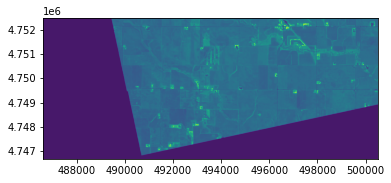

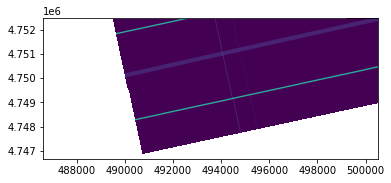

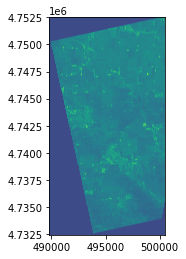

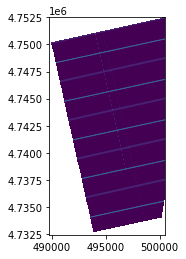

In [164]:
for imgfile, udmfile in zip(imgfiles, udmfiles):
    for file in (imgfile, udmfile):
        with rasterio.open(file) as img:
            plot.show(img)

Okay, we got some NDVI images down! Things we would like to do: visualize NDVI using the special NDVI colormap, view image and udm side by side